## Notebook for interpreting ML through SHAP

#### Model: LightGBM (Oxidative stability)

#### Splitting: Random

**Created on 21st September, 2022; remodified on 13th February, 2024**

In [1]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial'
import matplotlib.colors as mcolors
import seaborn as sns
import pandas as pd
import numpy as np
#import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, LassoCV, \
    RidgeClassifier, Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR, SVC
from sklearn.gaussian_process import GaussianProcessRegressor, GaussianProcessClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel, WhiteKernel, \
RationalQuadratic, ExpSineSquared, DotProduct
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, \
precision_score, auc
import sys
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import pickle
#import optuna
import lightgbm as lgb
from lightgbm import LGBMRegressor
import shap
lgb.__version__

'4.1.0'

In [2]:
%%bash
pwd
ls -ltr

/Users/riteshk/Library/CloudStorage/Box-Box/Research-postdoc/liquid-electrolyte-ML/Science-rev-1/oxidative-stability_1.1/lgbm_trials/random-split
total 38176
-rw-------@  1 riteshk  staff  3960002 Feb 13 15:13 train_fgrp_feat.csv
-rw-------@  1 riteshk  staff   495572 Feb 13 15:13 val_fgrp_feat.csv
-rw-------@  1 riteshk  staff   497131 Feb 13 15:13 test_fgrp_feat.csv
-rw-------@  1 riteshk  staff   714945 Feb 13 15:14 all_oxstab.csv
drwxr-xr-x  18 riteshk  staff      576 Feb 14 11:24 old-model_zero_columns
-rw-r--r--   1 riteshk  staff      436 Feb 14 12:10 best-paramters_lgbr_random.txt
-rw-r--r--   1 riteshk  staff     1302 Feb 14 12:10 best-paramters_lgbr_all.txt
-rw-r--r--   1 riteshk  staff   932994 Feb 14 12:20 lgbm_oxstab_rand_fold_1.sav
-rw-r--r--   1 riteshk  staff   908767 Feb 14 12:20 lgbm_oxstab_rand_fold_2.sav
-rw-r--r--   1 riteshk  staff   932000 Feb 14 12:20 lgbm_oxstab_rand_fold_3.sav
-rw-r--r--   1 riteshk  staff   923899 Feb 14 12:20 lgbm_oxstab_rand_fold_4.sav
-rw-

In [3]:
train_df = pd.read_csv('train_fgrp_feat.csv')
val_df = pd.read_csv('val_fgrp_feat.csv')
test_df = pd.read_csv('test_fgrp_feat.csv')
train_df

,smiles,fr_func_grp_1_solv,fr_func_grp_2_solv,fr_func_grp_3_solv,fr_func_grp_4_solv,fr_func_grp_5_solv,fr_func_grp_6_solv,fr_func_grp_7_solv,fr_func_grp_8_solv,fr_func_grp_9_solv,...,clogp,molar_refractivity,tpsa,frac_sp3,hall_kier_alpha,labute_ASA,num_valence_electron,max_partial_charge,min_partial_charge,IE
0,COCCOc1cscc1OC,0,0,0,0,0,0,0,0,0,...,1.78190,48.2420,27.69,0.500000,-0.74,75.872171,68,0.171467,-0.491993,4.306098
1,c1c(c2c(cc1)nccn2)C(=O)O,0,0,0,0,0,0,0,0,0,...,1.32800,46.4973,63.08,0.000000,-1.97,73.873062,64,0.337476,-0.477581,5.330098
2,C=Cc1cccc2c1[nH]sn2OCCOC,0,0,0,0,0,0,0,0,0,...,2.70270,68.0537,33.73,0.272727,-1.17,99.445369,86,0.103226,-0.382191,3.957699
3,c1ccc(cc1)C1(CCCC1)O,0,0,0,0,0,0,0,0,0,...,2.44820,48.8068,20.23,0.454545,-0.82,73.044516,64,0.089612,-0.385172,5.178552
4,C(#N)C1=COC(=CO1)N,0,0,0,0,0,0,0,0,0,...,0.15578,28.1364,68.27,0.000000,-1.63,51.773543,46,0.237928,-0.445084,3.910692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14500,CC(C)(C)c1cc(C#N)c2c(c1)ONO2,0,0,0,0,0,0,0,0,0,...,2.04658,54.2487,54.28,0.363636,-1.73,88.327892,78,0.213150,-0.369549,4.638594
14501,C=Cc1cscc1F,0,0,0,0,0,0,0,0,0,...,2.53020,34.3680,0.00,0.000000,-0.63,51.277583,42,0.140567,-0.205425,4.756748
14502,n1c(cncc1C)C,0,0,0,0,0,0,0,0,0,...,1.09344,31.5060,25.78,0.333333,-0.92,48.600583,42,0.055846,-0.260951,5.327466
14503,c1ccc(cc1)[C@@H]1[C@H](C(=O)O)SCCS1,2,0,0,0,0,0,0,0,0,...,2.66090,65.5228,37.30,0.363636,-0.61,97.452258,80,0.317615,-0.480376,4.915535


In [4]:
df_all = pd.concat([train_df, val_df, test_df], axis=0, ignore_index=True)
df_all.reset_index(drop=True, inplace=True)
zero_columns = list(df_all.columns[(df_all == 0).all()]) ## oxstab dataset has columns with only zero entries so have to remove them, otherwise causes problem with Sobol analysis
zero_columns

['fr_func_grp_6_solv',
 'fr_func_grp_16_solv',
 'fr_func_grp_22_solv',
 'fr_func_grp_24_solv',
 'fr_func_grp_26_solv',
 'fr_func_grp_28_solv',
 'fr_func_grp_33_solv',
 'fr_func_grp_38_solv',
 'fr_func_grp_41_solv']

In [5]:
df_all.drop(columns=zero_columns, inplace=True)
train_df.drop(columns=zero_columns, inplace=True)
val_df.drop(columns=zero_columns, inplace=True)
test_df.drop(columns=zero_columns, inplace=True)
df_all.reset_index(drop=True, inplace=True)
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [6]:
X_train = train_df.iloc[:,1:-1]
y_train = train_df.iloc[:,-1]

X_test = test_df.iloc[:,1:-1]
y_test = test_df.iloc[:,-1]

X_val = val_df.iloc[:,1:-1]
y_val = val_df.iloc[:,-1]

std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_train_std = pd.DataFrame(X_train_std, columns=X_train.columns)
X_test_std  = std_scale.transform(X_test)
X_test_std = pd.DataFrame(X_test_std, columns=X_train.columns)
X_val_std  = std_scale.transform(X_val)
X_val_std = pd.DataFrame(X_val_std, columns=X_train.columns)

X_train_ = np.array(X_train_std)
X_val_ = np.array(X_val_std)
X_test_ = np.array(X_test_std)

In [7]:
pred_array = []

lgbm_models = []
for i in range(1,6):
    filename = f'./lgbm_oxstab_rand_fold_{i}.sav'
    loaded_model = pickle.load(open(filename, 'rb'))
    lgbm_models.append(loaded_model)
    y_pred_test = loaded_model.predict(X_test_)
    pred_array.append(y_pred_test)

y_l = x_l = np.linspace(-6, -0.5, 100)
y_pred_test_avg = np.mean(pred_array, axis=0)
y_pred_test_avg = np.ravel(y_pred_test_avg)
y_pred_test_std = np.std(pred_array, axis=0)
y_pred_test_std = np.ravel(y_pred_test_std)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test_avg)); mae_test = mean_absolute_error(y_test, y_pred_test_avg); r2_test = r2_score(y_test, y_pred_test_avg)
print(f"Avg RMSE test: {rmse_test}, Avg MAE test: {mae_test}, Avg R2 test: {r2_test}")

Avg RMSE test: 0.34302621199127203, Avg MAE test: 0.22461921268782126, Avg R2 test: 0.9139721187672729


In [8]:
# model = lgbm_models[0] ## chosing the first model to get the SHAP values

In [8]:
X_all = df_all.iloc[:,1:-1]
X_all

,fr_func_grp_1_solv,fr_func_grp_2_solv,fr_func_grp_3_solv,fr_func_grp_4_solv,fr_func_grp_5_solv,fr_func_grp_7_solv,fr_func_grp_8_solv,fr_func_grp_9_solv,fr_func_grp_10_solv,fr_func_grp_11_solv,...,mol_sssr,clogp,molar_refractivity,tpsa,frac_sp3,hall_kier_alpha,labute_ASA,num_valence_electron,max_partial_charge,min_partial_charge
0,0,0,0,0,0,0,0,0,3,0,...,1,1.78190,48.2420,27.69,0.500000,-0.74,75.872171,68,0.171467,-0.491993
1,0,0,0,0,0,0,0,0,0,0,...,2,1.32800,46.4973,63.08,0.000000,-1.97,73.873062,64,0.337476,-0.477581
2,0,0,0,0,0,0,0,0,1,0,...,2,2.70270,68.0537,33.73,0.272727,-1.17,99.445369,86,0.103226,-0.382191
3,0,0,0,0,0,0,0,0,1,0,...,2,2.44820,48.8068,20.23,0.454545,-0.82,73.044516,64,0.089612,-0.385172
4,0,0,0,0,0,0,0,0,0,0,...,1,0.15578,28.1364,68.27,0.000000,-1.63,51.773543,46,0.237928,-0.445084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18128,0,0,0,0,1,0,0,0,1,0,...,1,1.83230,37.3748,20.23,0.142857,-0.53,58.893845,48,0.068139,-0.391680
18129,0,0,0,0,0,0,0,0,0,0,...,1,1.64958,34.2400,42.25,0.285714,-1.43,59.163537,52,0.238068,-0.464407
18130,0,0,0,0,0,0,0,0,1,0,...,1,-0.75462,27.3338,62.48,0.800000,-0.63,52.607092,50,0.280664,-0.372224
18131,0,0,0,0,0,0,0,0,0,0,...,2,2.97090,65.8291,58.41,0.400000,-1.43,98.212013,86,0.177580,-0.305088


In [10]:
# explainerModel = shap.TreeExplainer(model = model)
# shap_values = explainerModel.shap_values(X_all)

In [ ]:
# ## save the SHAP values
# cols_X = X_all.columns
# cols_shap = [('shap_' + cols_X[i]) for i in range(len(cols_X))]
# shap_df = pd.DataFrame(shap_values)
# shap_df.columns = cols_shap
# # shap_df.to_csv('shap_values_all.csv', index=False)
# shap_df

In [ ]:
# comb_df = pd.concat([X_all,shap_df], axis=1)
# comb_df['IE'] = df_all['IE']
# comb_df

In [9]:
shap_values_all = []
for i in range(5):
    model = lgbm_models[i] ## models trained on each fold
    explainerModel = shap.TreeExplainer(model = model)
    shap_values = explainerModel.shap_values(X_all)
    shap_values_all.append(shap_values)

shap_values_all = np.array(shap_values_all)
shap_values_all_mean = np.mean(shap_values_all, axis=0) ## average SHAP values across all models
cols_X = X_all.columns
cols_shap = [('shap_' + cols_X[i]) for i in range(len(cols_X))]
shap_df = pd.DataFrame(shap_values_all_mean)
shap_df.columns = cols_shap
# shap_df.to_csv('shap_values_all.csv', index=False)

comb_df = pd.concat([X_all,shap_df], axis=1)
comb_df['IE'] = df_all['IE']
comb_df

,fr_func_grp_1_solv,fr_func_grp_2_solv,fr_func_grp_3_solv,fr_func_grp_4_solv,fr_func_grp_5_solv,fr_func_grp_7_solv,fr_func_grp_8_solv,fr_func_grp_9_solv,fr_func_grp_10_solv,fr_func_grp_11_solv,...,shap_clogp,shap_molar_refractivity,shap_tpsa,shap_frac_sp3,shap_hall_kier_alpha,shap_labute_ASA,shap_num_valence_electron,shap_max_partial_charge,shap_min_partial_charge,IE
0,0,0,0,0,0,0,0,0,3,0,...,0.231263,-1.391193,0.525512,0.009015,0.058948,0.176059,-0.174269,0.086129,0.000201,4.306098
1,0,0,0,0,0,0,0,0,0,0,...,0.097498,-1.431493,0.666074,0.051868,0.132676,0.179685,-0.126096,0.083858,0.113906,5.330098
2,0,0,0,0,0,0,0,0,1,0,...,0.376206,-1.379483,0.576636,0.141789,0.009341,0.162966,-0.135689,0.014577,0.037560,3.957699
3,0,0,0,0,0,0,0,0,1,0,...,0.388201,-1.352896,0.559980,0.031935,0.050739,0.163925,-0.126012,0.020931,0.014217,5.178552
4,0,0,0,0,0,0,0,0,0,0,...,0.008303,-1.557078,0.808763,0.002147,0.090052,0.189039,-0.143350,0.132496,-0.044256,3.910692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18128,0,0,0,0,1,0,0,0,1,0,...,0.248886,-1.343175,0.541216,0.033793,0.036225,0.192827,-0.165900,0.082091,-0.007397,5.163176
18129,0,0,0,0,0,0,0,0,0,0,...,0.153351,-1.512190,0.743501,0.066262,0.151107,0.187380,-0.147830,0.144759,-0.013601,4.477547
18130,0,0,0,0,0,0,0,0,1,0,...,-0.141788,-1.549622,0.583166,0.070469,-0.051792,0.194916,-0.161012,0.143659,-0.075355,6.066940
18131,0,0,0,0,0,0,0,0,0,0,...,0.373643,-1.430095,0.686235,0.051811,0.089795,0.160358,-0.126712,0.101477,-0.038347,4.017905


**SHAP summary plot**

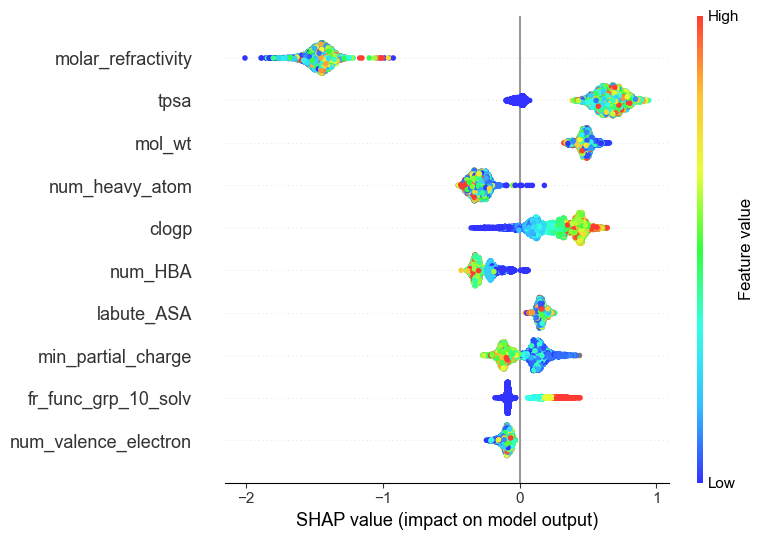

In [28]:
## Color scheme according to origin plots
c1 = '#3333FF'; c1 = mcolors.to_rgb(c1)
c2 = '#33C2FF'; c2 = mcolors.to_rgb(c2)
c3 = '#33FFE8'; c3 = mcolors.to_rgb(c3)
c4 = '#33FF3B'; c4 = mcolors.to_rgb(c4)
c5 = '#E9FF33'; c5 = mcolors.to_rgb(c5)
c6 = '#FFC133'; c6 = mcolors.to_rgb(c6)
c7 = '#FF3B33'; c7 = mcolors.to_rgb(c7)
# cmap1_or = mcolors.LinearSegmentedColormap.from_list("", [c7,c6,c5,c4,c3,c2,c1]) ## from red to blue
cmap1 = mcolors.LinearSegmentedColormap.from_list("", [c1,c2,c3,c4,c5,c6,c7]) ## from blue to red
shap.summary_plot(shap_values, X_all, max_display=10, show=False, cmap=cmap1)
ax = plt.gca()
ax.set_xticks([-2,-1,0,1])
plt.savefig('shap_lgbm_random_summary_oxstab.eps', dpi=300)

**SHAP dependence plots**

In [24]:
comb_df = comb_df.sort_values(by=['fr_func_grp_10_solv'], ascending=True)

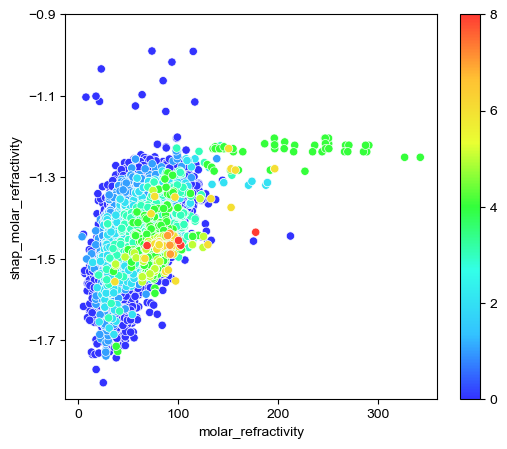

In [26]:
## For molar refractivity
fig, ax = plt.subplots(figsize=(6, 5))
ax = sns.scatterplot(x='molar_refractivity', y='shap_molar_refractivity', data=comb_df, hue='fr_func_grp_10_solv', palette=cmap1)
norm = plt.Normalize(df_all['fr_func_grp_10_solv'].min(), df_all['fr_func_grp_10_solv'].max())
sm = plt.cm.ScalarMappable(cmap=cmap1, norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.set_yticks([-1.7, -1.5, -1.3, -1.1, -0.9])
ax.set_xticks([0,100,200,300])
ax.figure.colorbar(sm, ticks=[0, 2, 4, 6, 8])
plt.savefig('shap_lgbm_random_molar_refractivity_dependence_oxstab.eps', dpi=300)

In [20]:
# comb_df = comb_df.sort_values(by=['mol_wt'], ascending=True)
comb_df = comb_df.sort_values(by=['fr_func_grp_34_solv'], ascending=True)

In [ ]:
# ## For fraction of F -- not using as the trend is flat!!
# fig, ax = plt.subplots(figsize=(6, 5))
# ax = sns.scatterplot(x='fr_func_grp_34_solv', y='shap_fr_func_grp_34_solv', data=comb_df, hue='mol_wt', palette=cmap1)
# norm = plt.Normalize(df_all['mol_wt'].min(), df_all['mol_wt'].max())
# sm = plt.cm.ScalarMappable(cmap=cmap1, norm=norm)
# sm.set_array([])

# # Remove the legend and add a colorbar
# ax.get_legend().remove()
# # ax.set_yticks([-1, -0.5, 0, 0.5])
# ax.figure.colorbar(sm, ticks=[50, 250, 500, 750, 1000, 1200])
# # ax.figure.colorbar(sm)
# # plt.savefig('shap_lgbm_random_frag_F_dependence_oxstab.eps', dpi=300)

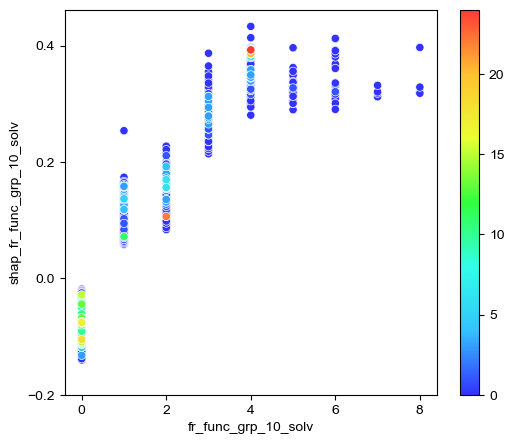

In [23]:
## For fraction of O
fig, ax = plt.subplots(figsize=(6, 5))
# ax = sns.scatterplot(x='fr_func_grp_10_solv', y='shap_fr_func_grp_10_solv', data=comb_df, hue='mol_wt', palette=cmap1)
ax = sns.scatterplot(x='fr_func_grp_10_solv', y='shap_fr_func_grp_10_solv', data=comb_df, hue='fr_func_grp_34_solv', palette=cmap1)
# norm = plt.Normalize(df_all['mol_wt'].min(), df_all['mol_wt'].max())
norm = plt.Normalize(df_all['fr_func_grp_34_solv'].min(), df_all['fr_func_grp_34_solv'].max())
sm = plt.cm.ScalarMappable(cmap=cmap1, norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.set_yticks([-0.2, 0.0, 0.2, 0.4])
ax.figure.colorbar(sm, ticks=[0, 5, 10, 15, 20, 25])
# ax.figure.colorbar(sm)
plt.savefig('shap_lgbm_random_frag_O_dependence_oxstab.eps', dpi=300)

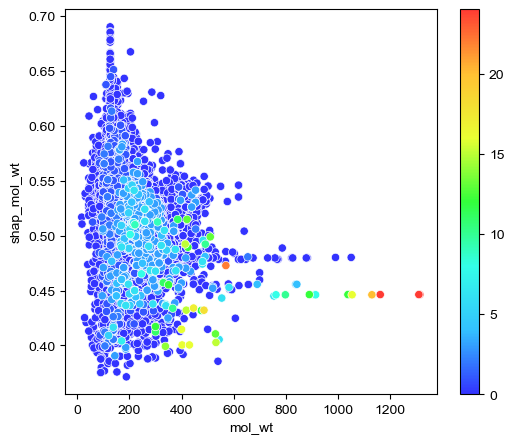

In [30]:
# comb_df = comb_df.sort_values(by=['fr_func_grp_34_solv'], ascending=True)
# # shap.dependence_plot('mol_wt', shap_values, X_all, interaction_index='fr_func_grp_34_solv')
# fig, ax = plt.subplots(figsize=(6, 5))
# ax = sns.scatterplot(x='mol_wt', y='shap_mol_wt', data=comb_df, hue='fr_func_grp_34_solv', palette=cmap1)
# norm = plt.Normalize(df_all['fr_func_grp_34_solv'].min(), df_all['fr_func_grp_34_solv'].max())
# sm = plt.cm.ScalarMappable(cmap=cmap1, norm=norm)
# sm.set_array([])

# # Remove the legend and add a colorbar
# ax.get_legend().remove()
# # ax.set_yticks([-1, -0.5, 0, 0.5])
# # ax.figure.colorbar(sm, ticks=[50, 250, 500, 750, 1000, 1200])
# ax.figure.colorbar(sm)
# # plt.savefig('shap_lgbm_random_frag_F_dependence_oxstab.eps', dpi=300)